# CS 436 CS5310 - Computer Vision - Assignment#4 - Part#1

*__Submission Instructions:__*
- Rename this notebook to `PA4_rollnumber.ipynb` before submission on LMS.
- Code for all the tasks must be written in this notebook (you do not need to submit any other files).
- The output of all cells must be present in the version of the notebook you submit.
- The university honor code should be maintained. Any violation, if found, will result in disciplinary action.

In [0]:
#Executed on Colab
#Import all the required libraries
import os
import keras
from keras.datasets import fashion_mnist
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Activation, Input, Embedding, LSTM, Dense, Lambda, GaussianNoise, concatenate
from keras.models import Model
import numpy as np
import pandas as pd
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Activation
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from keras.constraints import max_norm
from keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy
from keras.applications import vgg16
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from matplotlib import offsetbox
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Overview

In this assignment you will be exploring a few important concepts used in the deep learning projects:
- Training image classification algorithms using Deep Learning
- Dataset Analyses 
- Testing deep learning classifier with the test data
- Fine-tuning / Transfer Learning

We will be using the Fashion MNIST dataset that is provided by Keras. You will also be working with pretrained models, which can be downloaded from keras applications. You are **highly** encouraged to explore the images in dataset and model architectures in order to get the most out of this assignment. 

**_Dataset:_**
Fashion-MNIST is a dataset of  article images from a e-commerce website named zalando with 70,000 images of size (28x28x1) each belonging to one of the 10 classes.

**_Pretrained Models:_** 
Can be found [here](https://keras.io/applications/#applications)

## Task 1: Data Preparation for transfer learning

To prepare your data:
- Download the Fashion MNIST dataset
- Split it into train, validation, and test sets
- Convert the labels into categorical one hot encoded labels
- Cast the images as float and normalize the values between zero and one
- The Fashion MNIST dataset contains images of shape (28,28,1), the mimumm (height,width,channels) required by our pretrained model(in this case vgg-16) is (32,32,3)
- Convert the images in the datset to shape (32,32,3)

In [0]:
nb_classes = 10
#Download Fashion MNIST dataset(Done for you)
(X_Train, y_Train), (X_test, y_test) = fashion_mnist.load_data()
#Split the fashion MNIST dataset into train, validation and test sets (Done for you)
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, test_size=0.20)

#Convert y_train,y_val and y_test to categorical binary values 
#TO DO
#Hint
y_train = to_categorical(y_train,nb_classes)

y_val = to_categorical(y_val,nb_classes)
y_test = to_categorical(y_test,nb_classes)
#See function "np_utils.to_categorical()"

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
y_train.shape

(48000, 10)

In [0]:
#Reshape your dataset to batch_size, width, height, #channels(Done for you)
X_train = X_train.reshape(48000, 28, 28, 1)
X_val = X_val.reshape(12000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
#Convert your dataset to float type
#TO DO
X_train=X_train.astype(np.float32)
X_val=X_val.astype(np.float32)
X_test=X_test.astype(np.float32)

#Normalize the values
#TO DO
X_train= (X_train-np.mean(X_train)) / np.std(X_train)
X_val=(X_val -np.mean(X_val))  / np.std(X_val)
X_test=(X_test - np.mean(X_test)) /np.std(X_test)



In [0]:
#Preprocess the data for our pretrained model(requires 3 channels) and a mimimum height and width of 32.
#Convert all images to shape (32,32,3)
X_train_new=[]

for i in range(X_train.shape[0]):
  resized = cv2.resize(X_train[i],(32,32),interpolation = cv2.INTER_CUBIC)
  color = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
  X_train_new.append(color)

X_train_new= np.array(X_train_new)  

X_val_new=[]
for i in range(X_val.shape[0]):
  resized = cv2.resize(X_val[i],(32,32),interpolation = cv2.INTER_CUBIC)
  color = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
  X_val_new.append(color)

X_val_new = np.array(X_val_new)



In [0]:
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top layer
    nb_classes: number of classes
    Returns:
    new keras model with last fully connected layer
    """
    FC_SIZE=1024
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) 
    predictions = Dense(nb_classes, activation='softmax')(x) 
    model = Model(input=base_model.input, output=predictions)
    return model

## Task 2: Transfer Learning

Next you will employ Transfer Learning and finetune the pretrained vgg-16 model to better fit the Fashion MNIST data for 10 classes. You will:

- Change the number of nodes in the last FC layer according to the number of classes i.e. 10 
- Freeze everything except the FC layers and train it using the train split of our dataset (using appropriate hyperparameters), validating the network for validation split of data.
- Plot loss/accuracy vs epochs curves for your simulation



In [0]:
#Load the keras base model excluding the top layer
#TO DO
#Hint
#base_model=vgg16.VGG16(...)
base_model = VGG16(weights='imagenet', include_top=False,input_tensor=None, input_shape=(32,32,3), pooling=None, classes=nb_classes)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
#Since we will be using the pretrained weights for the image net dataset we will freeze all layers of our base model(Done for you)
for layer in base_model.layers:
    layer.trainable = False
#We will now add a new last layer according to the number of classes in our dataset using the "add_new_last_layer()" function provided to you
#TO DO
#Hint


vgg_imagenet_new= add_new_last_layer(base_model,nb_classes)

#Print Model Summary(Done for you)
vgg_imagenet_new.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
#Intialize Optimizer for our model(Done for you). You can try using different optimizers with different values
adam=Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#Compile Model
#TO DO
#Hint

vgg_imagenet_new.compile(loss='binary_crossentropy',
                                  optimizer=adam,
                                  metrics=['accuracy'])

In [0]:
# Learnt these in Deep Learning

if not os.path.exists('./'+'vgg_imagenet_new'):
    os.mkdir('vgg_imagenet_new')

checkpoint = ModelCheckpoint('vgg_imagenet_new'+'/''vgg_imagenet_new'+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger('vgg_imagenet_new'+'/logs.csv', separator=',', append=True)


callbacks = [checkpoint, cvslogger]


In [0]:
# Learnt in DL
def batch_generator(df,labels, batch_size = 32):
    
    total_samples = len(df)
    total_batches = int(np.ceil(total_samples / batch_size))

    
    while True:
      start = 0
      stop = batch_size
      for i in range(total_batches):
        if i == total_batches - 1:
          
          yield (df[start:] , labels[start:])
        else:
          yield (df[start:stop], labels[start:stop])
          start = stop
          stop += (batch_size)
    

In [0]:
train_gen = batch_generator(df= X_train_new,labels= y_train)
val_gen = batch_generator(df=X_val_new,labels = y_val)



In [0]:
a = next(val_gen)

In [0]:
a[1].shape

(32, 10)

In [15]:
#Train the vgg-16 model
epochs = 5
batch_size =  32
#TO DO
#Hint
history=vgg_imagenet_new.fit_generator(train_gen, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=val_gen, shuffle=True,  steps_per_epoch=(int(np.ceil(len(X_train_new)/batch_size))), validation_steps=(int(len(X_val_new)//batch_size)), validation_freq=1)

#The history variable will be used later to plot accuracy and loss curves

Epoch 1/5
1500/1500 [==============================] - 434s 289ms/step - loss: 0.0841 - accuracy: 0.9663 - val_loss: 0.0845 - val_accuracy: 0.9716

Epoch 00001: val_loss improved from inf to 0.08447, saving model to vgg_imagenet_new/vgg_imagenet_new-01-0.08.h5
Epoch 2/5
1500/1500 [==============================] - 430s 287ms/step - loss: 0.0660 - accuracy: 0.9734 - val_loss: 0.0808 - val_accuracy: 0.9736

Epoch 00002: val_loss improved from 0.08447 to 0.08082, saving model to vgg_imagenet_new/vgg_imagenet_new-02-0.08.h5
Epoch 3/5
1500/1500 [==============================] - 430s 287ms/step - loss: 0.0586 - accuracy: 0.9765 - val_loss: 0.0781 - val_accuracy: 0.9741

Epoch 00003: val_loss improved from 0.08082 to 0.07814, saving model to vgg_imagenet_new/vgg_imagenet_new-03-0.08.h5
Epoch 4/5
1500/1500 [==============================] - 430s 286ms/step - loss: 0.0529 - accuracy: 0.9791 - val_loss: 0.0875 - val_accuracy: 0.9741

Epoch 00004: val_loss did not improve from 0.07814
Epoch 5/5


In [0]:
  #Lets test our transfer learned model on the test set
#Preprocess the test data just like we did before i.e convert all images to shape (32,32,3)


X_test_new = []
for i in range(X_test.shape[0]):
  resized = cv2.resize(X_test[i],(32,32),interpolation = cv2.INTER_CUBIC)
  color = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
  X_test_new.append(color)

X_test_new = np.array(X_test_new)


In [0]:
test_gen = batch_generator(df = X_test_new,labels = y_test)

In [18]:
#Evaluate the transfer learned model
#TO DO
#Hint
#vgg_imagenet_new.evaluate(...)
hist=vgg_imagenet_new.evaluate_generator(test_gen, steps= np.ceil(len(X_test_new)/batch_size), callbacks=callbacks,  verbose=1)


313/313 [==============================] - 72s 229ms/step


In [0]:
#Plot training and validation accuracy curves using matplot lib
#Hint

#Values for training and validation accuarcy can be obtained using history.history['accuracy'] and history.history['val_accuracy'] respectively
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    plt.plot(x_axis, histories.history[metric[0]], label=metric[0]+'_'+names)
    plt.plot(x_axis, histories.history[metric[1]], label=metric[1]+'_'+names)
    plt.scatter(x_axis, histories.history[metric[0]])
    plt.scatter(x_axis, histories.history[metric[1]])
    
    plt.legend()
    plt.title(metric[0])
    plt.show()

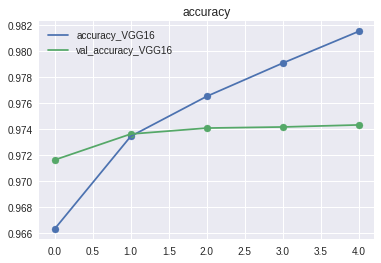

In [20]:
# 
names = 'VGG16'
metrics = ['accuracy','val_accuracy']
plotHistory(history,names,metrics)

In [0]:
#Plot training and validation loss curves using matplot lib
#Hint
#Values for training and validation loss can be obtained using history.history['loss'] and history.history['val_loss'] respectively

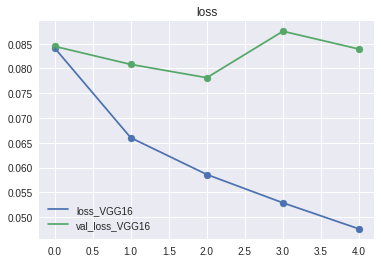

In [22]:
# Training 
names = 'VGG16'
metrics = ['loss','val_loss']
plotHistory(history,names,metrics)

## Task 3: Network Evaluation

Next you will test your finetuned model by plotting a confusion matrix between classes predicted. You will:

- Test your model for images in the test set
- Construct a multiclass confusion matrix (for 10 classes) for actual and predicted class of each image and visualize the confusion matrix as a heatmap

*You can use scikit-learn's `metrics.confusion_matrix` function. Consult the relevant documentation.* 

In [23]:
# Getting predicted values for the test data 

preds = vgg_imagenet_new.predict_generator(test_gen, steps=int(np.ceil(len(X_test_new)/batch_size)), verbose=1)

preds = np.argmax(preds, axis=1)

313/313 [==============================] - 71s 228ms/step


In [0]:
#preds = to_categorical(preds,nb_classes)


In [0]:
y = np.argmax(y_test,axis=1)


In [0]:
true = y_test
conf_mat = sat_con_mat = confusion_matrix(y,preds)

In [0]:
def plot_confusion_matrix(conf_mat):
    classes = [0,1,2,3,4,5,6,7,8,9]
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(17,11))
    sn.set(font_scale=0.7)
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

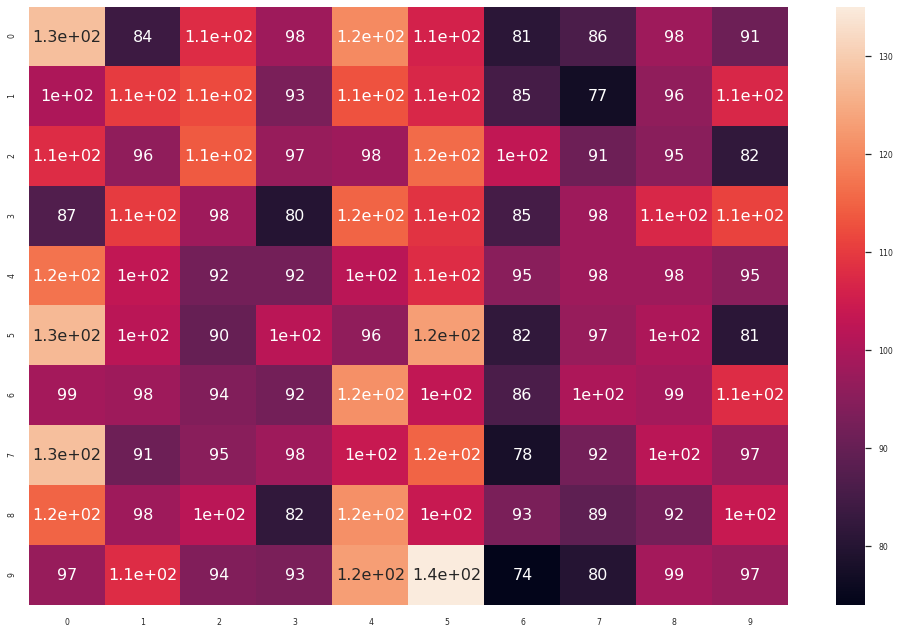

In [27]:
plot_confusion_matrix(conf_mat)